# Exploração de dados COVID-19 com Python e QGIS

### Recolha de dados

Para nos mantermos atualizados, recolhemos os últimos dados a um ficheiro atualizado na internet por fontes fidedignas. 

Para o efeito, usamos o pacote pandas que permite ler ficheiros csv e efetuar parsing do mesmo facilmente.

In [212]:
import pandas as pd
ww_df = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv")
ww_df.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
0,01/05/2020,1,5,2020,222,4,Afghanistan,AF,AFG,37172386.0,Asia
1,30/04/2020,30,4,2020,122,0,Afghanistan,AF,AFG,37172386.0,Asia
2,29/04/2020,29,4,2020,124,3,Afghanistan,AF,AFG,37172386.0,Asia
3,28/04/2020,28,4,2020,172,0,Afghanistan,AF,AFG,37172386.0,Asia
4,27/04/2020,27,4,2020,68,10,Afghanistan,AF,AFG,37172386.0,Asia


### Seleção dos países

Aqui selecionamos os países nos quais estamos interessados.

Para efeitos de demonstração foram escolhidos alguns países da Europa Ocidental/Central.

In [213]:
# Choosing the countries to watch
selected_countries = ["Portugal", "Spain", "France", "Italy", "Germany", 
                      "Austria", "Belgium", "Netherlands", "Denmark", 
                      "Switzerland", "United Kingdom", "Ireland"]

### Preparação dos Dados (Python)

Para a preparação dos dados para análise com o Python, criamos uma função que permite recolher a informação relativa a apenas um país.

Dentro desta função, são também efetuadas algumas alterações ao modo de apresentação dos dados.

In [214]:
from datetime import datetime

def get_country (dataframe, country):
    
    # Keeping original dataframe intact
    df = dataframe
    # Changing date format
    df.loc[:, 'date'] = df.apply(lambda x:datetime.strptime("{0} {1} {2}".format(x['year'],x['month'], x['day']), "%Y %m %d"), axis=1)
    # Setting new date as index
    df = df.set_index('date')
    # Renaming columns
    df = df.rename(columns={"countriesAndTerritories": "country", "continentExp": "continent", "popData2018": "population"})
    # Getting data of a single country
    df["country"] = list(map(lambda s: s.replace("_", " "), df["country"]))
    df = df[df["country"] == country]
    # Returning only relevant data and sorting by date
    return df[["cases", "deaths", "country", "continent", "population"]].sort_index()

get_country(ww_df, "Portugal").head()

,cases,deaths,country,continent,population
date,,,,,
2020-03-03,2,0,Portugal,Europe,10281762.0
2020-03-04,2,0,Portugal,Europe,10281762.0
2020-03-05,1,0,Portugal,Europe,10281762.0
2020-03-06,4,0,Portugal,Europe,10281762.0
2020-03-07,4,0,Portugal,Europe,10281762.0


### Filtragem dos países

Usamos então a função acima para recolher todos os países que listamos acima na seleção dos países.

In [215]:
# Mapping the get_country function to every selected country
eu_dfs = list(map(lambda c: get_country(ww_df, c), selected_countries))

eu_dfs[0].head()

,cases,deaths,country,continent,population
date,,,,,
2020-03-03,2,0,Portugal,Europe,10281762.0
2020-03-04,2,0,Portugal,Europe,10281762.0
2020-03-05,1,0,Portugal,Europe,10281762.0
2020-03-06,4,0,Portugal,Europe,10281762.0
2020-03-07,4,0,Portugal,Europe,10281762.0


### Normalização dos dados

Aqui definimos umas funções que normalizarão os dados entre os nossos países. 

Para que seja possível comparar os dados entre os países, é preciso ter em conta a população de cada país e para o efeito foram criadas as seguintes funções.

In [216]:
# Gets the percentage of positive cases by population
def get_percent_cases_by_pop (df):
    
    return df["cases"].div(df["population"]) * 100
    
# Gets the percentage of deaths by population
def get_percent_deaths_by_pop (df):
    
    return df["deaths"].div(df["population"]) * 100
    
get_percent_cases_by_pop(eu_dfs[1])

date
2019-12-31    0.000000
2020-01-01    0.000000
2020-01-02    0.000000
2020-01-03    0.000000
2020-01-04    0.000000
                ...   
2020-04-26    0.003700
2020-04-27    0.003919
2020-04-28    0.002799
2020-04-29    0.004589
2020-05-01    0.001109
Length: 122, dtype: float64

### Análise de infetados

Aqui é feita a preparação dos dados dos testes que retornaram positivo. É aplicada a função acima para normalizar o número de casos e são concatenados todos os países.

Além disso, é aplicada uma soma cumulativa dos casos que retornaram positivo nos vários dias. 

É de notar que esta soma não reflete a percentagem de população infetada, pois ao somar os testes positivos podemos estar a contar pessoas que testaram positivo várias vezes. 

In [217]:
import math
import numpy as np

# Mapping the get_percentage_of_cases functions and concatenating every country dataframe
eu_df_cases = pd.concat(list(map(lambda df: get_percent_cases_by_pop(df), eu_dfs)), axis=1, keys=selected_countries)
# Getting rid of NaN values
eu_df_cases = eu_df_cases.transform(lambda v: list(map(lambda e: 0.0 if isinstance(e, float) and math.isnan(e) else e, v)))
# Cumulative sum
eu_df_cases = eu_df_cases.cumsum()
# Getting rid of rows of all 0's
eu_df_cases = eu_df_cases[(eu_df_cases > 0).apply(np.any, axis=1)]

eu_df_cases

,Portugal,Spain,France,Italy,Germany,Austria,Belgium,Netherlands,Denmark,Switzerland,United Kingdom,Ireland
date,,,,,,,,,,,,
2020-01-25,0.000000,0.000000,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-26,0.000000,0.000000,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-27,0.000000,0.000000,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-28,0.000000,0.000000,0.000004,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-29,0.000000,0.000000,0.000006,0.000000,0.000005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-27,0.232100,0.448305,0.185968,0.327107,0.187142,0.171685,0.403902,0.219633,0.147910,0.340255,0.229873,0.396868
2020-04-28,0.233686,0.451105,0.187752,0.329985,0.188522,0.172442,0.408744,0.221954,0.150032,0.341465,0.236353,0.404821
2020-04-29,0.236555,0.455693,0.189342,0.333445,0.190094,0.173098,0.414408,0.222947,0.152671,0.342639,0.242363,0.409539


### Análise de mortes

Aqui é feita a preparação dos dados das fatalidades causadas pelo COVID-19 ao longo dos dias. É aplicada a função acima para normalizar o número de mortos e são concatenados todos os países.

Além disso, é aplicada uma soma cumulativa dos mortos pelos vários dias. 

Esta soma já reflete melhor a percentagem de população morta pelo COVID-19, apesar do número de pessoas por país se manter estática com a passagem dos dias (o que não acontece na vida real). 

In [218]:
# Mapping the get_percentage_of_deaths functions and concatenating every country dataframe
eu_df_deaths = pd.concat(list(map(lambda df: get_percent_deaths_by_pop(df), eu_dfs)), axis=1, keys=selected_countries)
# Getting rid of NaN values
eu_df_deaths = eu_df_deaths.transform(lambda v: list(map(lambda e: 0.0 if isinstance(e, float) and math.isnan(e) else e, v)))
# Cumulative sum
eu_df_deaths = eu_df_deaths.cumsum()
# Getting rid of rows of all 0's
eu_df_deaths = eu_df_deaths[(eu_df_deaths > 0).apply(np.any, axis=1)]

eu_df_deaths

,Portugal,Spain,France,Italy,Germany,Austria,Belgium,Netherlands,Denmark,Switzerland,United Kingdom,Ireland
date,,,,,,,,,,,,
2020-02-15,0.000000,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-02-16,0.000000,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-02-17,0.000000,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-02-18,0.000000,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-02-19,0.000000,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-27,0.008783,0.049632,0.034120,0.044090,0.006934,0.006126,0.062108,0.025971,0.007279,0.015687,0.036179,0.022396
2020-04-28,0.009026,0.050985,0.034772,0.044641,0.007130,0.006205,0.063097,0.026220,0.007365,0.015875,0.036687,0.022705
2020-04-29,0.009220,0.051954,0.035320,0.045273,0.007374,0.006432,0.064183,0.026499,0.007486,0.016192,0.038054,0.023880


### Apresentação dos dados

Aqui apresentamos na forma de gráficos os dados que estivemos a analisar. 

Nestes gráficos podemos ver as curvas tão faladas pelos cientistas e a capacidade que cada país teve para "suavizar a curva" com as medidas de isolamento social.

Além disso, apresentamos os gráficos de infetados e mortes lado a lado para que seja possível testemunhar a capacidade que os países de tratar os infetados e evitar que a infeção levasse à fatalidade.

Text(0.5, 1.0, 'COVID-19 Death Toll')

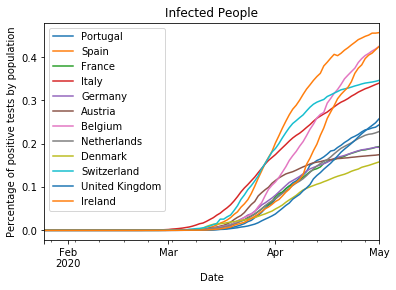

<Figure size 432x288 with 0 Axes>

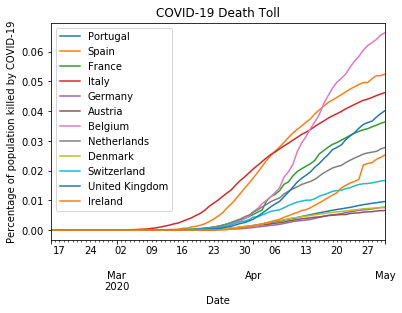

In [219]:
import matplotlib.pyplot as plt

# Plotting the percentage of cases in the chosen countries 
eu_df_cases.plot()
plt.xlabel("Date")
plt.ylabel("Percentage of positive tests by population")
plt.title("Infected People")

plt.figure()

# Plotting the percentage of deaths in the chosen countries 
eu_df_deaths.plot()
plt.xlabel("Date")
plt.ylabel("Percentage of population killed by COVID-19")
plt.title("COVID-19 Death Toll")

### Preparação dos dados QGIS

A apresentação em gráficos apesar de muito explícita, pode ser um pouco limitada. 

Então, dada a natureza geográfica do problema em questão, recorremos ao QGIS para apresentar de maneira geográfica os dados.

Então começamos por preparar uns csvs para facilitar a leitura e apresentação dos dados no QGIS.

In [221]:
# Keeping original dataframe intact
df = ww_df
# Changing the date format
df.loc[:, 'date'] = df.apply(lambda x:datetime.strptime("{0} {1} {2}".format(x['year'],x['month'], x['day']), "%Y %m %d"), axis=1)
# Renaming columns
df = df.rename(columns={"countriesAndTerritories": "country", "continentExp": "continent", "popData2018": "population"})
# Reshaping the dataframe
df = df[["date","cases", "deaths", "country", "continent", "population"]].sort_index()

# Renaming some countries ("United_Kingdom" => "United Kingdom")
df["country"] = list(map(lambda s: s.replace("_", " "), df["country"]))
# Dropping continent info
df = df.drop(["continent"], axis=1)
# Getting only selected countries
df = df[df.apply(lambda v: True if v[3] in selected_countries else False, axis=1)]

# Applying normalization by population of the number of cases and deaths
df["cases"] = df["cases"] / df["population"] * 100
df["deaths"] = df["deaths"] / df["population"] * 100

# Getting cuulative cases and deaths
df.insert(2, "cases_cumulative", "")
df.insert(4, "deaths_cumulative", "")
for c in selected_countries:
    df.loc[df["country"] == c, 'cases_cumulative'] = df.sort_values("date").loc[df["country"] == c, "cases"].cumsum()
    df.loc[df["country"] == c, 'deaths_cumulative'] = df.sort_values("date").loc[df["country"] == c, "deaths"].cumsum()

# Saving the dataframe as csv
df.to_csv("cases_deaths_percent.csv")

# Saving a dataframe with only the countries as csv (for filtering in QGIS)
pd.DataFrame(data={'country': selected_countries}).to_csv("selected_countries.csv")

df

,date,cases,cases_cumulative,deaths,deaths_cumulative,country,population
787,2020-05-01,0.001051,0.174714,0.000045,0.00660108,Austria,8847037.0
788,2020-04-30,0.000565,0.173663,0.000124,0.00655587,Austria,8847037.0
789,2020-04-29,0.000656,0.173098,0.000226,0.00643153,Austria,8847037.0
790,2020-04-28,0.000757,0.172442,0.000079,0.00620547,Austria,8847037.0
791,2020-04-27,0.000622,0.171685,0.000068,0.00612634,Austria,8847037.0
...,...,...,...,...,...,...,...
13654,2020-01-04,0.000000,0,0.000000,0,United Kingdom,66488991.0
13655,2020-01-03,0.000000,0,0.000000,0,United Kingdom,66488991.0
13656,2020-01-02,0.000000,0,0.000000,0,United Kingdom,66488991.0
13657,2020-01-01,0.000000,0,0.000000,0,United Kingdom,66488991.0


### Resultados do QGIS

Com os ficheiros csv criados acima e um GeoPackage com o mapa mundo, podemos no QGIS criar uma Virtual Layer que resulta do Inner Join entre o geopackage e o csv com os casos e as mortes. 

Desse modo, podemos apresentar os dados obtidos num mapa e fornecer uma melhor visualização dos mesmos.

Uma maneira de o fazer é através da apresentação dos dados ao longo do tempo em forma de animação. Com recurso ao plugin TimeManager do QGIS é muito fácil fazer isso e abaixo apresentamos 2 gifs extraídos com esse plugin.

### Infetados dia a dia

Nesta animação conseguimos ver a comparação do número de infetados que são publicados todos os dias para os países que selecionamos acima. 

Estes números como foi dito acima são divididos pela população de cada país para que a comparação seja justa.

<img src="cases.gif" width="500" align="left">

### Mortos dia a dia

Nesta animação podemos ver a comparação do número de mortos que são publicados todos os dias para os países que selecionamos acima. 

Da mesma maneira que os infetados, estes números também são normalizados com população de cada país.

<img src="deaths.gif" width="500" align="left">

### Total de Mortos

Na animação seguinte testemunhamos a acumulação da percentagem de mortes em cada país que selecionamos. 

Esta visualização permite realmente comparar os países na sua totalidade de fatalidades.

<img src="death_toll.gif" width="500" align="left">